In [1]:

from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
import pandas as pd
circle = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})
circle.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


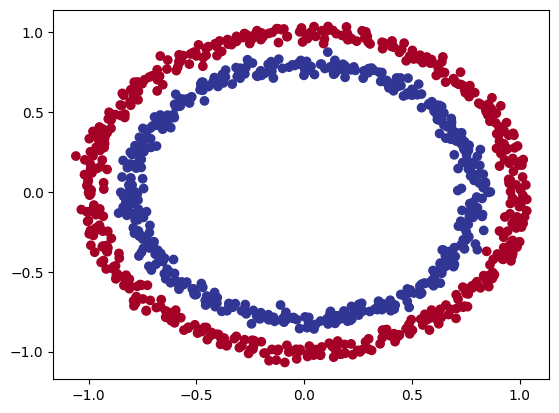

In [3]:
import matplotlib.pyplot as plt 

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [4]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [6]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [7]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

#### Model's output is logit -> y_prediction_probabilities -> y_preds_labels

In [9]:
y_logits = model_0(X_train.to(device))[:5]
y_prediction_probabilities = torch.sigmoid(y_logits)
y_pred = torch.round(y_prediction_probabilities)
y_pred.squeeze(dim=1)

tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [10]:
loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.01)

In [11]:
def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_pred)) * 100
    return accuracy

In [12]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
    
X_train[:5], X_test.shape, y_train.shape, y_test.shape

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], device='cuda:0'),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [13]:
def training_model(model, optimizer, loss_function):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    epochs = 1000

    for epoch in range(epochs):
        model.train()
        
        y_logits = model(X_train).squeeze(dim=1)
        
        y_pred_labels = torch.round(torch.sigmoid(y_logits))
        
        loss = loss_function(y_logits, y_train)
        
        train_accuracy = accuracy_function(y_pred=y_pred_labels, 
                                        y_true=y_train)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        model.eval()
        with torch.inference_mode():
            
            test_logits = model(X_test).squeeze(dim=1)
            
            test_pred_labels = torch.round(torch.sigmoid(test_logits))
            
            test_loss = loss_function(test_logits, y_test)
            
            test_accuracy = accuracy_function(y_pred=test_pred_labels,
                                            y_true=y_test)
            
            if epoch % 20 == 0:
                print(f"Epoch:{epoch}, Loss:{loss:.2f}, Train_accuracy:{train_accuracy:.2f}, Test_loss:{test_loss:.2f}, Test_accuracy:{test_accuracy:.2f}")
                

In [41]:
import requests
from pathlib import Path

if Path("hepler_functions.py").is_file():
    print("it is already existed")
else:
    print("Download helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py") 
    with open("helper_function.py", "wb") as f:
        f.write(request.content)
        
from helper_function import  plot_predictions, plot_decision_boundary

Download helper_function.py


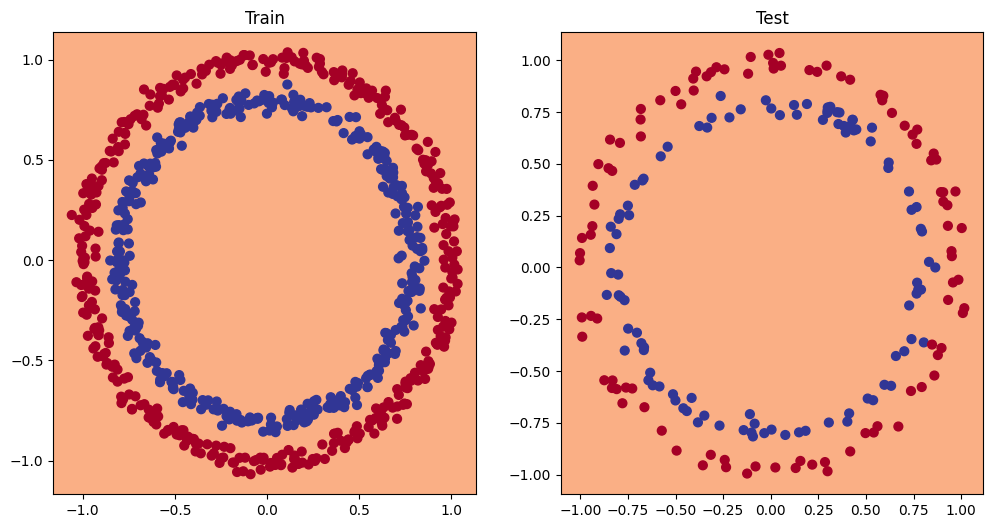

In [15]:
def print_picture(model):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, X_test, y_test)
print_picture(model_0)

In [16]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=10)
        self.layer_2 = nn.Linear(in_features=10,
                                 out_features=10)
        self.layer_3 = nn.Linear(in_features = 10,
                                 out_features=1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)

In [17]:
start = 0
end = 1
step = 0.01

weight = 0.7
bias = 0.3

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = X * weight + bias
split = int(len(X)* 0.8)

X_train, X_test, y_train, y_test = X[:split].to(device), X[split:].to(device), y[:split].to(device), y[split:].to(device)
X_train[:5]

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]], device='cuda:0')

In [18]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

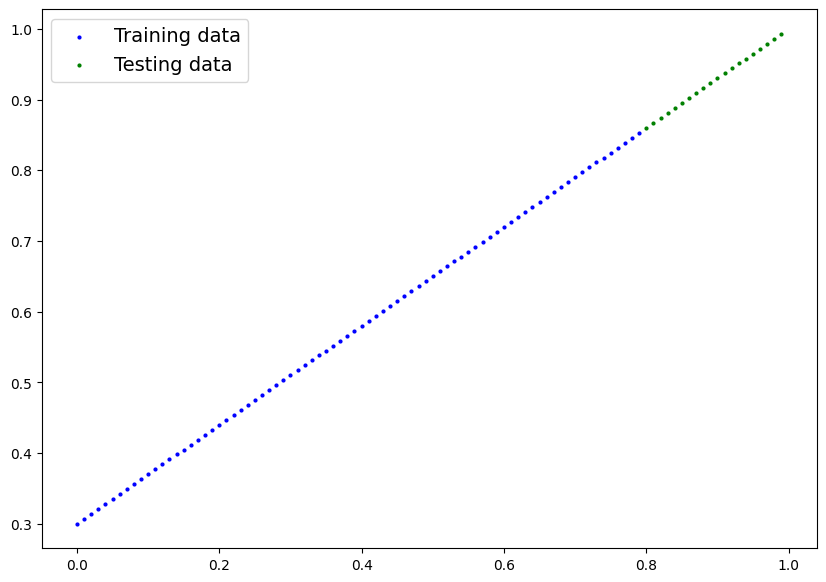

In [19]:
plot_predictions(train_data=X_train.cpu(),
                 train_labels=y_train.cpu(),
                 test_data=X_test.cpu(),
                 test_labels=y_test.cpu())

In [20]:
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

loss_function = nn.L1Loss()

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model_2.train()
    
    y_preds = model_2(X_train)

    loss = loss_function(y_preds, y_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_2.eval()
    
    with torch.inference_mode():
        
        test_logits = model_2(X_test)
        
        test_loss = loss_function(test_logits, y_test)
        if epoch % 100 == 0:
            print(f"Epoch:{epoch}, Loss:{loss:.5f}, Test_loss:{test_loss:.5f}")

Epoch:0, Loss:0.11700, Test_loss:0.22030
Epoch:100, Loss:0.11781, Test_loss:0.04520
Epoch:200, Loss:0.07122, Test_loss:0.01392
Epoch:300, Loss:0.06529, Test_loss:0.01043
Epoch:400, Loss:0.05236, Test_loss:0.00938
Epoch:500, Loss:0.06759, Test_loss:0.01457
Epoch:600, Loss:0.05620, Test_loss:0.01502
Epoch:700, Loss:0.06213, Test_loss:0.00780
Epoch:800, Loss:0.04724, Test_loss:0.01086
Epoch:900, Loss:0.05827, Test_loss:0.01861


In [22]:
with torch.inference_mode():
    model_2.eval()
    y_preds_new = model_2(y_test)
    
y_preds_new[:5]

tensor([[0.7844],
        [0.7883],
        [0.7922],
        [0.7960],
        [0.7999]], device='cuda:0')

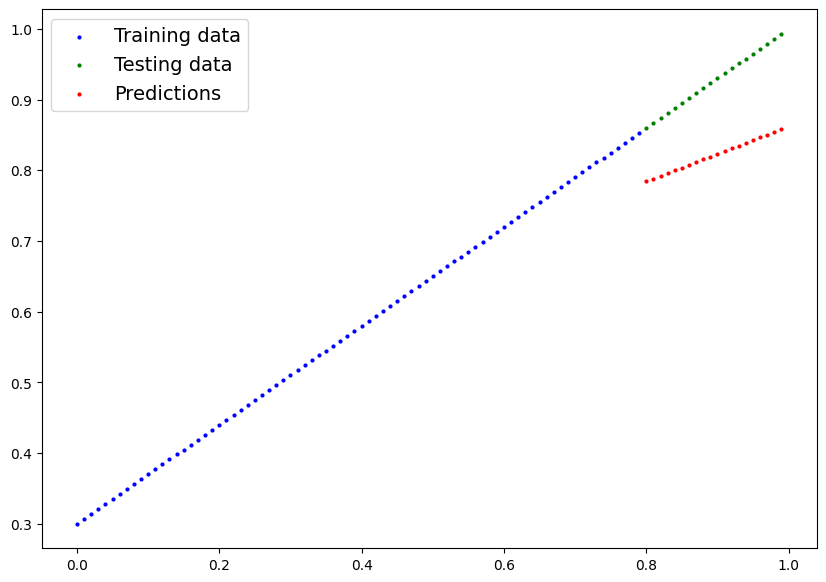

In [23]:
plot_predictions(train_data=X_train.cpu(),
                 train_labels=y_train.cpu(),
                 test_data=X_test.cpu(),
                 test_labels=y_test.cpu(),
                 predictions=y_preds_new.cpu())

In [24]:
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=128)
        self.layer_2 = nn.Linear(in_features=128, out_features=128)
        self.layer_3 = nn.Linear(in_features=128, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV3()
model_3.to(device)

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [25]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
X[:4], y[:4]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277]]),
 array([1, 1, 1, 1], dtype=int64))

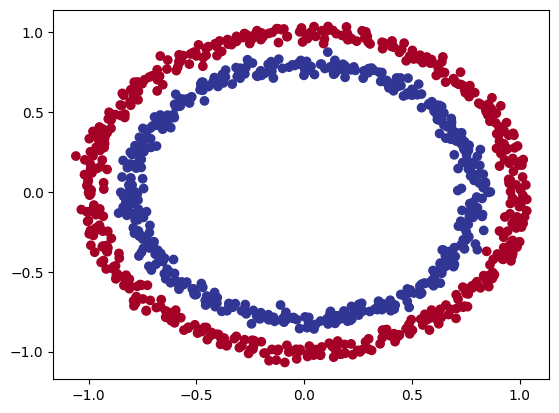

In [26]:
import matplotlib.pyplot as plt 

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [27]:
split = int(len(X) * 0.8)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = X[:split].to(device), X[split:].to(device), y[:split].to(device), y[split:].to(device)
y_test.shape

torch.Size([200])

In [28]:
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

loss_function = nn.BCEWithLogitsLoss()

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000

for epoch in range(epochs):
    model_3.train()
    
    y_logits = model_3(X_train).squeeze(dim=1)
    
    y_pred_labels = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_function(y_logits, y_train)
    
    acc = accuracy_function(y_true=y_train,
                            y_pred=y_pred_labels)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze(dim=1)
        
        test_pred_labels = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_function(test_logits, y_test)
        
        test_acc = accuracy_function(y_true=y_test,
                                     y_pred=test_pred_labels)
        
        if epoch % 100 == 0:
            print(f"Epoch:{epoch} | Loss:{loss:.5f} | Accuracy:{acc:.5f} | Test Loss:{test_loss:.5f} | Test_Accuracy:{test_acc:.5f}")

Epoch:0 | Loss:0.69398 | Accuracy:49.87500 | Test Loss:0.69278 | Test_Accuracy:50.50000
Epoch:100 | Loss:0.67024 | Accuracy:74.12500 | Test Loss:0.67572 | Test_Accuracy:64.50000
Epoch:200 | Loss:0.62211 | Accuracy:93.50000 | Test Loss:0.62839 | Test_Accuracy:92.50000
Epoch:300 | Loss:0.50499 | Accuracy:98.75000 | Test Loss:0.50712 | Test_Accuracy:99.00000
Epoch:400 | Loss:0.31304 | Accuracy:99.87500 | Test Loss:0.30782 | Test_Accuracy:100.00000
Epoch:500 | Loss:0.18017 | Accuracy:99.87500 | Test Loss:0.17475 | Test_Accuracy:99.50000
Epoch:600 | Loss:0.09680 | Accuracy:100.00000 | Test Loss:0.09381 | Test_Accuracy:100.00000
Epoch:700 | Loss:0.06158 | Accuracy:100.00000 | Test Loss:0.06063 | Test_Accuracy:100.00000
Epoch:800 | Loss:0.04339 | Accuracy:100.00000 | Test Loss:0.04376 | Test_Accuracy:100.00000
Epoch:900 | Loss:0.03284 | Accuracy:100.00000 | Test Loss:0.03400 | Test_Accuracy:100.00000
Epoch:1000 | Loss:0.02614 | Accuracy:100.00000 | Test Loss:0.02787 | Test_Accuracy:100.00000


In [30]:
with torch.inference_mode():
    model_3.eval()
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze(dim=1)
y_preds[:10], y_test[:10]
    

(tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 0.], device='cuda:0'))

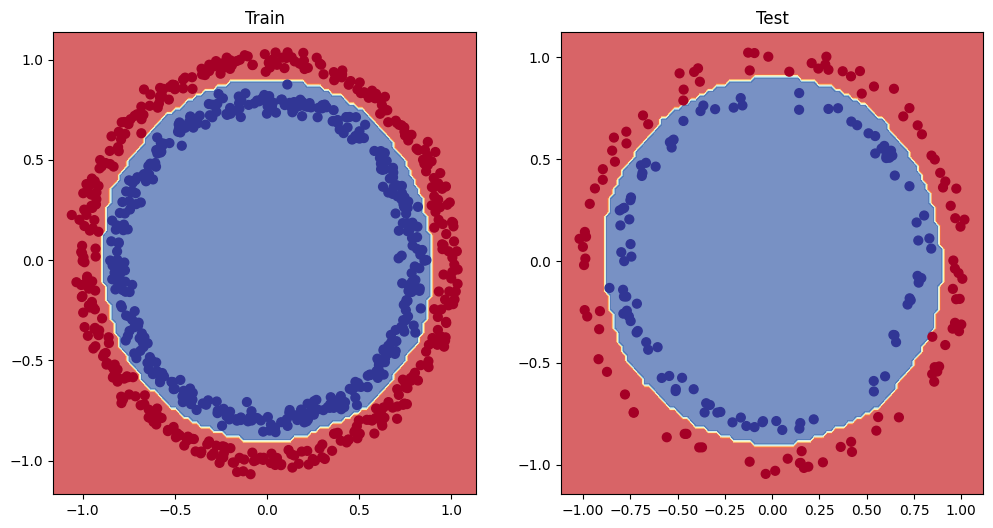

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)


In [32]:
import torch
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED)
type(X_blob)

numpy.ndarray

In [33]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


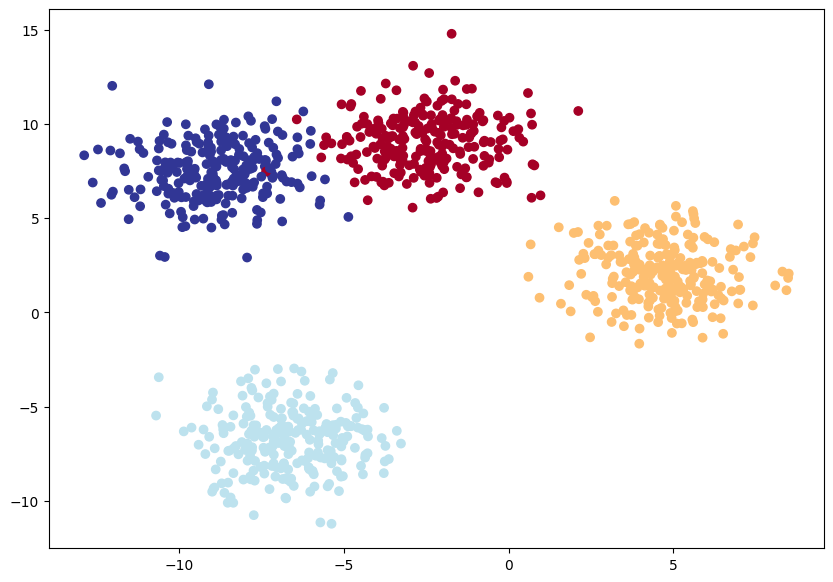

In [34]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size = 0.2,
                                                    random_state = RANDOM_SEED)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [35]:
class BlobModel(nn.Module):
    """Initistelizes multi_classification model
    Args:
        input_feature (int): Number of input feature to the model
        output_feature (int): Number of out feature to the model
        hidden_units (int): Number of hidden unit between layers, default 8
        
    Return:
        A random tensor value
        
    Example:
        """
    def __init__(self, input_feature, output_feature, hidden_units = 8):
        super().__init__()
        self.Linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_feature, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_feature)
        )
        
    def forward(self, x):
        return self.Linear_layer_stack(x)
      
model_4 = BlobModel(input_feature=2,
                    output_feature=4,
                    hidden_units=8).to(device)        
model_4

BlobModel(
  (Linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [36]:
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

loss_function = nn.CrossEntropyLoss()

In [37]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    model_4.train() 

    y_logits = model_4(X_blob_train)
    
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    acc = accuracy_function(y_true=y_blob_train,
                            y_pred=y_preds)
    
    loss = loss_function(y_logits, y_blob_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    
    with torch.inference_mode():
        model_4.eval()
        
        test_logits = model_4(X_blob_test)
        
        test_preds = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
        
        test_acc = accuracy_function(y_true=y_blob_test,
                                     y_pred=test_preds)
        
        test_loss = loss_function(test_logits, y_blob_test)
        
        if epoch % 10 == 0:
            print(f"Epoch:{epoch}|Loss:{loss:.4f}|Acc:{acc:.4f}|Test Loss{test_loss:.4f}|Test Acc:{test_acc:.4f}")

Epoch:0|Loss:1.0432|Acc:65.5000|Test Loss0.5786|Test Acc:95.5000
Epoch:10|Loss:0.1440|Acc:99.1250|Test Loss0.1304|Test Acc:99.0000
Epoch:20|Loss:0.0806|Acc:99.1250|Test Loss0.0722|Test Acc:99.5000
Epoch:30|Loss:0.0592|Acc:99.1250|Test Loss0.0513|Test Acc:99.5000
Epoch:40|Loss:0.0489|Acc:99.0000|Test Loss0.0410|Test Acc:99.5000
Epoch:50|Loss:0.0429|Acc:99.0000|Test Loss0.0349|Test Acc:99.5000
Epoch:60|Loss:0.0391|Acc:99.0000|Test Loss0.0308|Test Acc:99.5000
Epoch:70|Loss:0.0364|Acc:99.0000|Test Loss0.0280|Test Acc:99.5000
Epoch:80|Loss:0.0345|Acc:99.0000|Test Loss0.0259|Test Acc:99.5000
Epoch:90|Loss:0.0330|Acc:99.1250|Test Loss0.0242|Test Acc:99.5000


In [38]:
with torch.inference_mode():
    model_4.eval()
    y_preds = model_4(X_blob_test)

y_preds[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

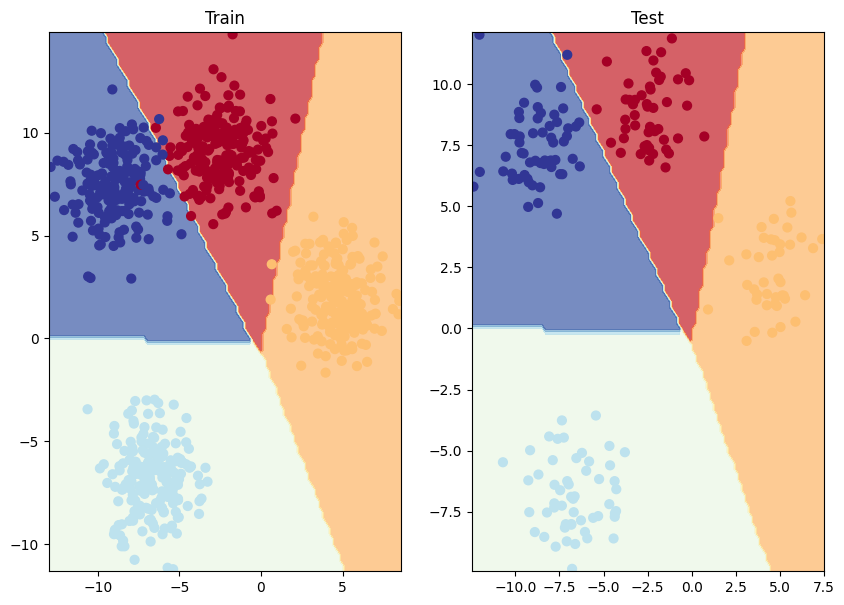

In [39]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [40]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task="MULTICLASS", num_classes=4).to(device)

torchmetric_accuracy(y_preds, y_blob_test)

c:\Users\Jason\Desktop\pytorch_pra\studysession\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


tensor(0.9950, device='cuda:0')